In [1]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms


# Holographic Light Transport Assignment

## Instructions

### 1. Download the Sample Hologram
Download the sample hologram image from the following link:
[Sample Hologram](https://github.com/kaanaksit/odak/blob/master/test/data/sample_hologram.png)

### 2. Image Parameters
- **Resolution**: (2400, 4094)
- **Wavelengths**: [639e-9, 515e-9, 473e-9] (in meters)
- **Pixel Pitch**: 3.74e-6 (in meters)
- **Distances**: [-2.5e-3, 0, 2.5e-3] (in meters)

### 3. Phase-only Hologram
- **Amplitude**: 1
- **Phase**: `sample_hologram`

### 4. Create a Complex Field
Create a complex field where:
- **Amplitude**: 1
- **Phase**: provided by the `sample_hologram`

### 5. Phase Normalization
Normalize the phase of the complex field:
- **Range**: 0 - 255 (image pixel values)
- **Convert to radians**: `phase = sample_hologram / 255 * 2 * pi`

### 6. Define the Source Plane
```python
source_plane = complex_field(amplitude, phase)


## single channel

In [5]:
def amplitude_tensor(image_path):
    image = Image.open(image_path)
    width = image.size[0]
    height = image.size[1]
    # generate 2-D amplitude tensor same size as the phase tensor all values are 1.0
    amplitude_tensor = torch.ones([3,height,width])
    return amplitude_tensor
amplitudeTensor = amplitude_tensor("..\data\images\sample_hologram.png")
amplitudeTensor.shape

torch.Size([3, 2400, 4094])

In [7]:
def phase_image2phase_tensor(image_path):
    image = Image.open(image_path) # convert the image to gray scale
    transform = transforms.ToTensor()
    image_tensor = transform(image) # convert the image to tensor

    # padding the tensor to make it the same size as the amplitude tensor
    # image_tensor = torch.nn.functional.pad(image_tensor, (image.size[0]//2, image.size[0]//2, image.size[1]//2, image.size[1]//2), mode='constant', value=0)
    
    image_tensor_normalized = image_tensor * 2 * math.pi
    return image_tensor_normalized # return the tensor between 0 and 2*pi
    
phaseTensor = phase_image2phase_tensor("..\data\images\sample_hologram.png")
print(phaseTensor.min())
print(phaseTensor.max())
phaseTensor.shape

tensor(0.)
tensor(6.2585)


torch.Size([3, 2400, 4094])

In [8]:
def source_plain(amplitude_tensor, phase_tensor):
    # generate source the source plain
    source = amplitude_tensor * torch.exp(1j * phase_tensor)
    return source

In [9]:
freq = torch.fft.fftfreq(9, 1)
print(freq)
print(torch.fft.fftshift(freq))
print(torch.fft.ifftshift(freq))


tensor([ 0.0000,  0.1111,  0.2222,  0.3333,  0.4444, -0.4444, -0.3333, -0.2222,
        -0.1111])
tensor([-0.4444, -0.3333, -0.2222, -0.1111,  0.0000,  0.1111,  0.2222,  0.3333,
         0.4444])
tensor([ 0.4444, -0.4444, -0.3333, -0.2222, -0.1111,  0.0000,  0.1111,  0.2222,
         0.3333])


In [10]:
def band_limited_angular_spectrum(
    amplitude=amplitudeTensor[0],
    phase=phaseTensor[0],
    z=0.0,
    wave_length=639e-9,
    pixel_pitch=3.74e-6,
    band_limit=True,
    debug=False,
):
    """
    Band-limited angular spectrum method for simulating the propagation of light.
    Parameters
    ----------
    amplitude : torch.Tensor
        The amplitude tensor of the light source.
    phase : torch.Tensor
        The phase tensor of the light source.
    z : float
        The propagation distance.
    wave_length : float
        The wavelength of the light source.
    pixel_pitch : float
        The sampling interval of the light source.
    band_limit : bool
        Whether to clip the frequency.
    debug : bool
        Whether to print debug information.
    Returns
    -------
    g_z_complex : torch.Tensor
        The complex amplitude tensor at the distance z.
    amplitude_z : torch.Tensor
        The amplitude tensor at the distance z.
    phase_z : torch.Tensor
        The phase tensor at the distance z.
    """

    if not isinstance(amplitude, torch.Tensor) or not isinstance(phase, torch.Tensor):
        raise ValueError("Amplitude tensor or phase tensor is required")
    if amplitude.shape != phase.shape:
        raise ValueError("Amplitude and phase tensors must have the same shape")

    dx = pixel_pitch  # the sampling interval
    sample_u = amplitude.shape[0]
    sample_v = amplitude.shape[1]
    S_x = sample_u * dx  # the x-size of the hologram plain
    S_y = sample_v * dx  # the y-size of the hologram plain

    # generate the 2-D frequency mesh
    freq_x = torch.fft.fftfreq(sample_u, dx)
    freq_y = torch.fft.fftfreq(sample_v, dx)

    if debug:
        print(
            "The highest positive frequency is u = {} and v = {}.".format(
                freq_x.max(), freq_y.max()
            )
        )
        print(
            "The highest negative frequency is u = {} and v = {}.".format(
                freq_x.min(), freq_y.min()
            )
        )
        print(
            "The resolution of the frequency is u = {} and v = {}.".format(
                freq_x[1] - freq_x[0], freq_y[1] - freq_y[0]
            )
        )

    freq_x_unsqueezed = freq_x.unsqueeze(1).expand(sample_u, sample_v)
    freq_y_unsqueezed = freq_y.unsqueeze(0).expand(sample_u, sample_v)

    freq_squared = 1 / wave_length**2
    freq_z_squared = freq_squared - freq_x_unsqueezed**2 - freq_y_unsqueezed**2
    freq_z_squared_clamped = torch.clamp(freq_z_squared, min=0)

    # transfer function
    H_FR = torch.exp(2j * torch.pi * z * torch.sqrt(freq_z_squared_clamped))

    if band_limit:
        # clipper the frequency
        d_u = 1 / S_x  # S_x instead of 2 * S_x
        d_v = 1 / S_y  # S_y instead of 2 * S_y
        u_limit = 1 / (math.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)
        v_limit = 1 / (math.sqrt((2 * d_v * z) ** 2 + 1) * wave_length)
        mask_u = torch.abs(freq_x) < u_limit
        mask_v = torch.abs(freq_y) < v_limit
        mask = mask_u.unsqueeze(1) & mask_v.unsqueeze(0)
        H_FR = H_FR * mask

    sourcePlain = source_plain(amplitude, phase)
    G_0 = torch.fft.fft2(sourcePlain)

    G_z = G_0 * H_FR

    # aperture = odak.learn.tools.mask.circular_binary_mask(sample_u, sample_v, sample_u//2)
    # G_z = aperture * G_z

    # inverse fourier transform
    g_z_complex = torch.fft.ifft2(G_z)
    amplitude_z = torch.abs(g_z_complex)
    phase_z = torch.angle(g_z_complex)

    if debug:
        if mask.sum() == sample_u * sample_v:
            print(
                "The maximum frequency is clipped to u = {} and v = {}.".format(
                    u_limit, v_limit
                )
            )
            print("The clipper is NOT working............")
        else:
            print(
                "The maximum frequency is clipped to u = {} and v = {}.".format(
                    u_limit, v_limit
                )
            )
            print("The clipper is working............")

    return g_z_complex, amplitude_z, phase_z

The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1367145.2378332615 and v = 1487636.6721598336.
The clipper is NOT working............


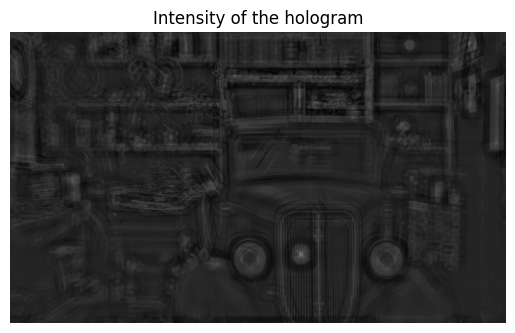

In [11]:
# test whether the clipping is working
g_z_complex, amplitude_z, phase_z = band_limited_angular_spectrum(amplitudeTensor[0], phaseTensor[0], z=2.5e-3, wave_length=639e-9, pixel_pitch=3.74e-6, band_limit=True, debug=True)
# plot the intensity of the hologram
intensity = amplitude_z**2
plt.imshow(intensity, cmap='gray')
plt.axis('off')
plt.title('Intensity of the hologram')
plt.show()

In [8]:
# generate the propagated wave by taking a list of z values
def propagate_wave(
    amplitude=amplitudeTensor[0],
    phase=phaseTensor[0],
    z_values=[-2.5e-3, 0, 2.5e-3],
    wave_length=639e-9,
    pixel_pitch=3.74e-6,
    plot=False,
):
    propagated_amplitude = []
    propagated_phase = []
    propagated_wave = []
    for z in z_values:
        g_z_complex, amplitude_z, phase_z = band_limited_angular_spectrum(
            amplitude=amplitude,
            phase=phase,
            z=z,
            wave_length=wave_length,
            pixel_pitch=pixel_pitch,
            band_limit=True,
            debug=True,
        )

        propagated_wave.append(g_z_complex)
        propagated_amplitude.append(amplitude_z)
        propagated_phase.append(phase_z)

    if plot:
        fig, axs = plt.subplots(len(z_values), 3, figsize=(20, len(z_values) * 5))
        for i in range(len(z_values)):
            axs[i, 0].imshow(
                torch.abs(propagated_wave[i]) ** 2, cmap="gray"
            )
            axs[i, 0].set_title("z = {} m".format(z_values[i]))
            axs[i, 1].imshow(propagated_amplitude[i], cmap="gray", vmin=0, vmax=1)
            axs[i, 1].set_title("z = {} m".format(z_values[i]))
            axs[i, 2].imshow(
                propagated_phase[i], cmap="gray", vmin=-math.pi, vmax=math.pi
            )
            axs[i, 2].set_title("z = {} m".format(z_values[i]))
        plt.show()
    return propagated_wave, propagated_amplitude, propagated_phase

The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1563393.6192726337 and v = 1564411.483525823.
The clipper is NOT working............
The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1560207.9671424064 and v = 1563312.3428854102.
The clipper is NOT working............
The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1555322.7896451717 and v = 1

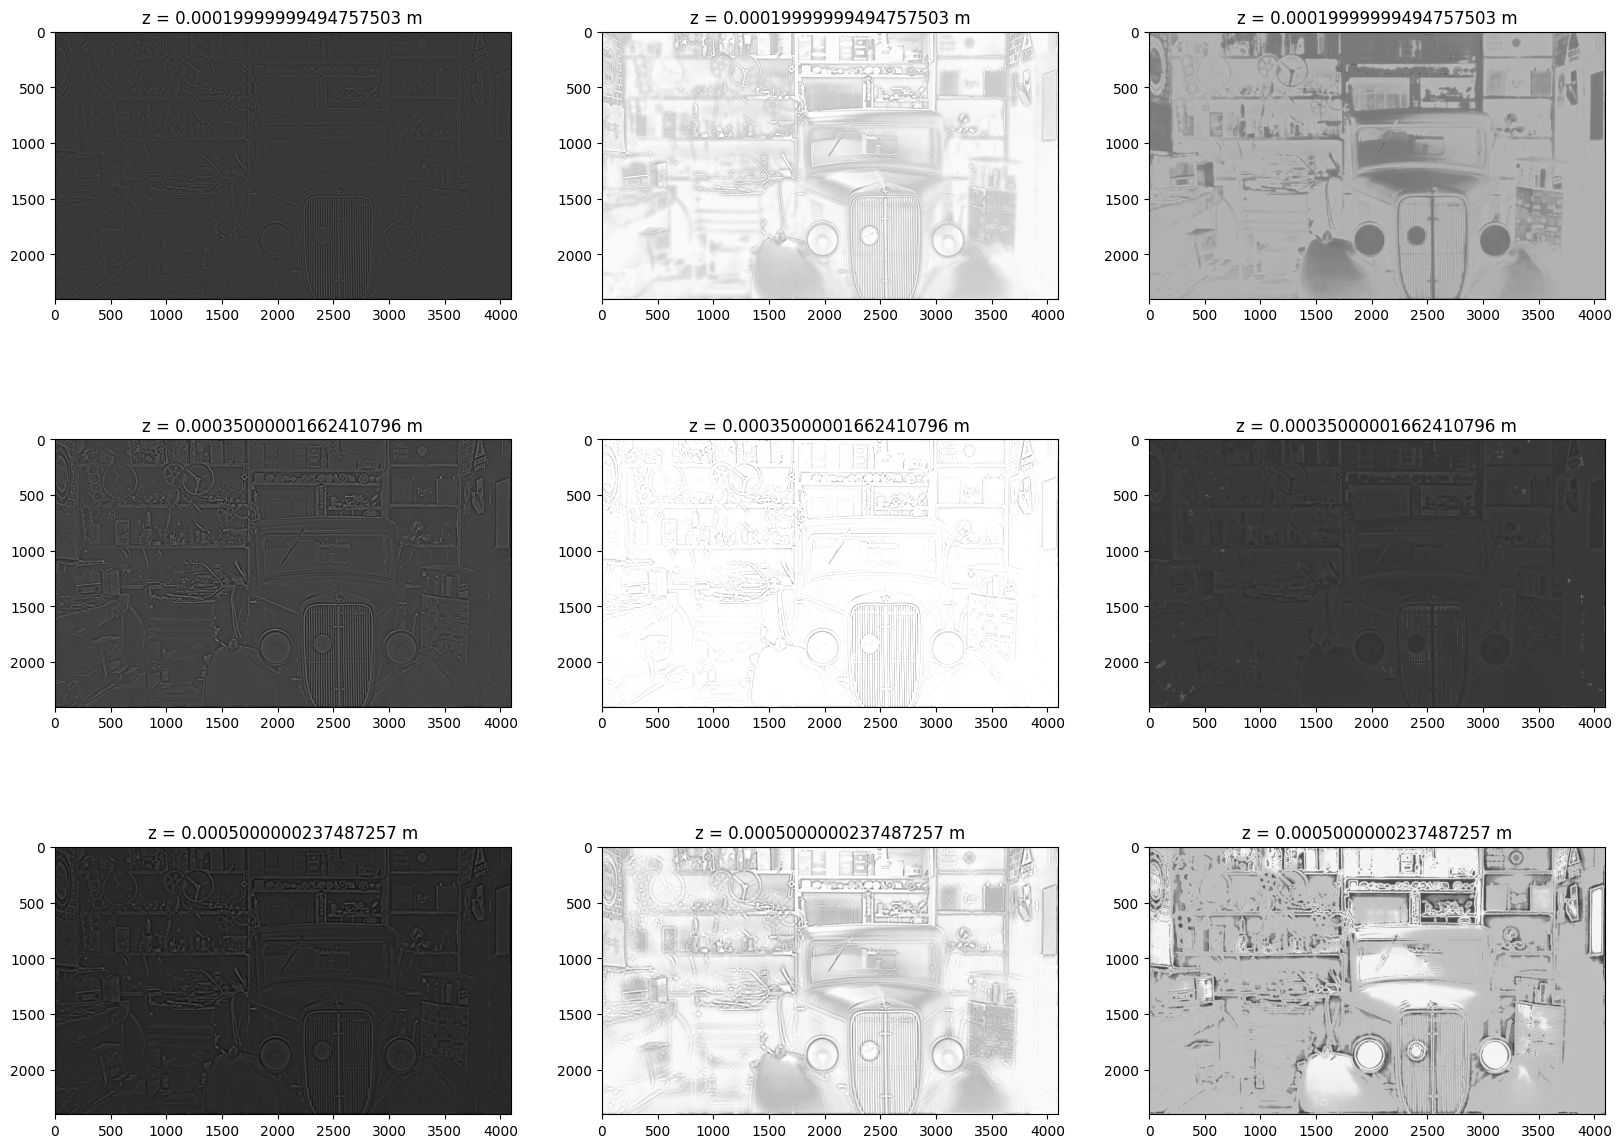

In [9]:
# generate a list of z values
# propagation_distance = torch.linspace(0.051, 0.07, 3)
# propagation_distance = torch.linspace(0.0508, 0.06, 20)
propagation_distance = torch.linspace(0.2e-3, 0.5e-3, 3)

propagated_wave, propagated_amplitude, propagated_phase = propagate_wave(
    plot=True, z_values=propagation_distance
)

## multi-channel

In [12]:
def intensity_normalizor(intensity):
    intensity_normalized = (
        255 * (intensity - intensity.min()) / (intensity.max() - intensity.min())
    )
    return intensity_normalized

In [11]:
def band_limited_angular_spectrum_multichannels(
    amplitude=amplitudeTensor,
    phase=phaseTensor,
    z=0.0,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    pixel_pitch=3.74e-6,
    band_limit=True,
    debug=False,
    plot=True,
    padded=False,
):
    if not isinstance(amplitude, torch.Tensor) or not isinstance(phase, torch.Tensor):
        raise ValueError("Amplitude tensor or phase tensor is required")
    if amplitude.shape != phase.shape:
        raise ValueError("Amplitude and phase tensors must have the same shape")

    if padded:
        print(amplitude.shape, phase.shape)
        amplitude = torch.nn.functional.pad(amplitude, (amplitude.shape[2]//2, amplitude.shape[2]//2, amplitude.shape[1]//2, amplitude.shape[1]//2), mode='constant', value=0)
        phase = torch.nn.functional.pad(phase, (phase.shape[2]//2, phase.shape[2]//2, phase.shape[1]//2, phase.shape[1]//2), mode='constant', value=0)
        print(amplitude.shape, phase.shape)

    dx = pixel_pitch  # the sampling interval
    sample_u = amplitude.shape[1]
    sample_v = amplitude.shape[2]
    S_x = sample_u * dx  # the x-size of the hologram plain
    S_y = sample_v * dx  # the y-size of the hologram plain

    # generate the 2-D frequency mesh
    freq_x = torch.fft.fftfreq(sample_u, dx)
    freq_y = torch.fft.fftfreq(sample_v, dx)
    if debug:
        print(
            "The highest positive frequency is u = {} and v = {}.".format(
                freq_x.max(), freq_y.max()
            )
        )
        print(
            "The highest negative frequency is u = {} and v = {}.".format(
                freq_x.min(), freq_y.min()
            )
        )
        print(
            "The resolution of the frequency is u = {} and v = {}.".format(
                freq_x[1] - freq_x[0], freq_y[1] - freq_y[0]
            )
        )

    freq_x_unsqueezed = freq_x.unsqueeze(1).expand(sample_u, sample_v)
    freq_y_unsqueezed = freq_y.unsqueeze(0).expand(sample_u, sample_v)

    freq_square = freq_x_unsqueezed**2 + freq_y_unsqueezed**2
    freq_cube = freq_square.unsqueeze(0).repeat(3, 1, 1)

    freq_max = 1 / wave_length**2
    freq_max_cube = freq_max.unsqueeze(1).unsqueeze(2).repeat(1, sample_u, sample_v)

    w_cube_0 = freq_max_cube - freq_cube
    mask_w_cube = w_cube_0 > 0
    w_cube = mask_w_cube * w_cube_0

    # transfer function
    H_FR = torch.exp(2j * math.pi * z * torch.sqrt(w_cube))
    # H_FR = torch.exp(1j * math.pi * z * (2/wave_length.unsqueeze(1).unsqueeze(2)-wave_length.unsqueeze(1).unsqueeze(2)*freq_cube))
    print(H_FR.shape)


    if band_limit:
        # clipper the frequency
        d_u = 1 / S_x  # S_x instead of 2 * S_x
        d_v = 1 / S_y  # S_y instead of 2 * S_y
        u_limit = 1 / (math.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)
        v_limit = 1 / (math.sqrt((2 * d_v * z) ** 2 + 1) * wave_length)
        mask_u = torch.abs(freq_x).unsqueeze(0).repeat(3, 1) < u_limit.unsqueeze(
            1
        ).expand(3, sample_u)
        mask_v = torch.abs(freq_y).unsqueeze(0).repeat(3, 1) < v_limit.unsqueeze(
            1
        ).expand(3, sample_v)
        mask = mask_u.unsqueeze(2) & mask_v.unsqueeze(1)
        H_FR = H_FR * mask

    print(H_FR.shape)

    sourcePlain = source_plain(amplitude, phase)
    G_0 = torch.fft.fft2(sourcePlain)
    G_z = G_0 * H_FR

    # inverse fourier transform
    g_z_complex = torch.fft.ifft2(G_z)

    if padded:
        # get the center part of the tensor
        g_z_complex = g_z_complex[
            :,
            sample_u // 4 : sample_u // 4 + sample_u // 2,
            sample_v // 4 : sample_v // 4 + sample_v // 2,
        ]

    amplitude_z = torch.abs(g_z_complex)
    phase_z = torch.angle(g_z_complex)

    if debug:
        if mask.sum() == sample_u * sample_v * 3:
            print(
                "The maximum frequency is clipped to u = {} and v = {}.".format(
                    u_limit, v_limit
                )
            )
            print("The clipper is NOT working............")
        else:
            print(
                "The maximum frequency is clipped to u = {} and v = {}.".format(
                    u_limit, v_limit
                )
            )
            print("The clipper is working............")
            
    if plot:
        intensity = torch.abs(g_z_complex) ** 2
        rgb_tensor_normalized = torch.stack(
            (
                intensity_normalizor(intensity[0]),
                intensity_normalizor(intensity[1]),
                intensity_normalizor(intensity[2]),
            ),
            dim=-1,
        )

        # rgb_tensor_normalized = torch.stack((intensity_normalizor(intensity[0]), torch.zeros_like(intensity[0]), torch.zeros_like(intensity[0])), dim=-1)
        # rgb_tensor_normalized = torch.stack((torch.zeros_like(intensity[0]), intensity_normalizor(intensity[1]), torch.zeros_like(intensity[0])), dim=-1)
        # rgb_tensor_normalized = torch.stack((torch.zeros_like(intensity[0]), torch.zeros_like(intensity[0]), intensity_normalizor(intensity[2])), dim=-1)

        rgb_numpy = rgb_tensor_normalized.numpy().astype(np.uint8)

        plt.figure(figsize=(20, 10))
        plt.imshow(rgb_numpy)

        plt.title("rgb of the reconstructed image at z = {} m".format(z))
        plt.show()

    return g_z_complex, amplitude_z, phase_z

torch.Size([3, 2400, 4094])
torch.Size([3, 2400, 4094])


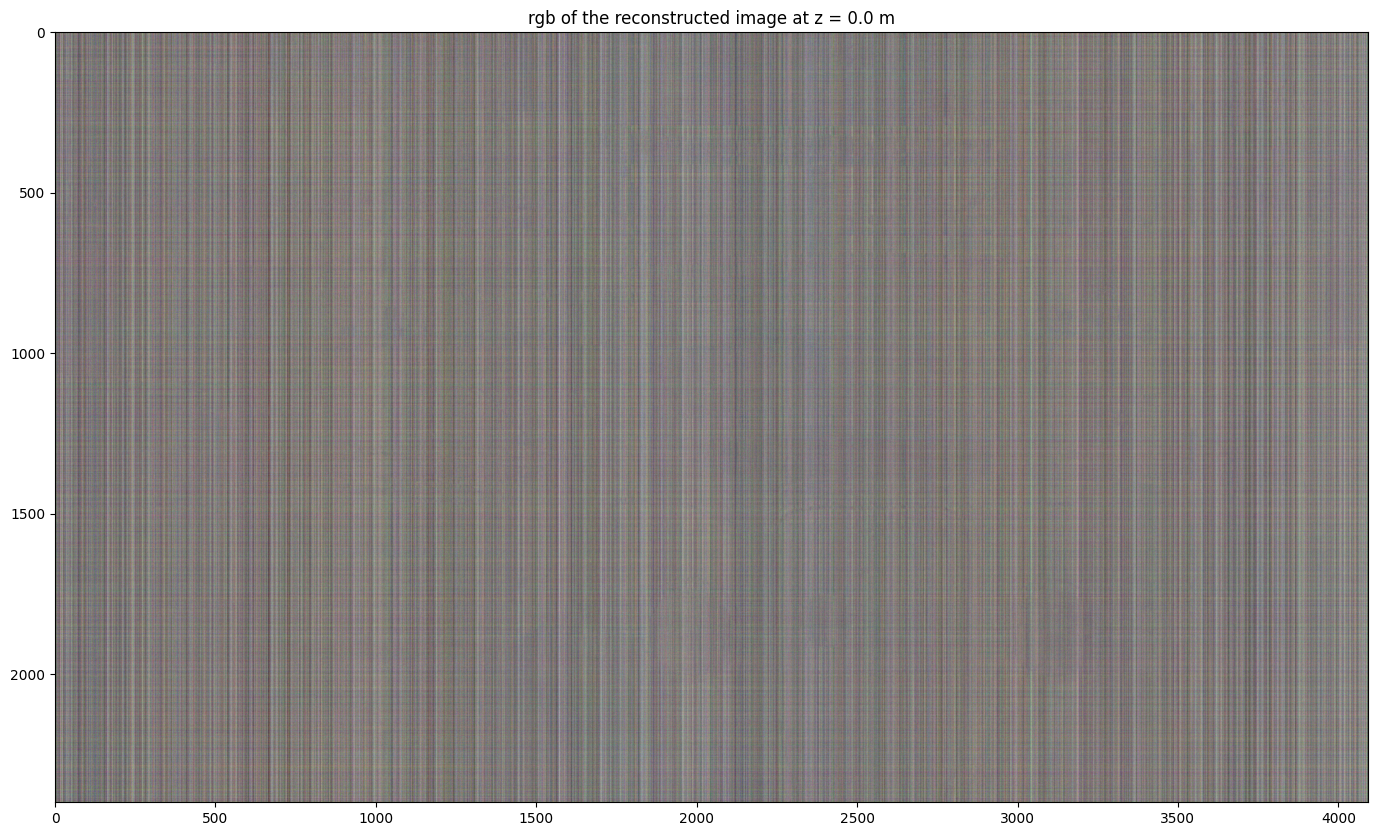

torch.Size([3, 2400, 4094])
torch.Size([3, 2400, 4094])


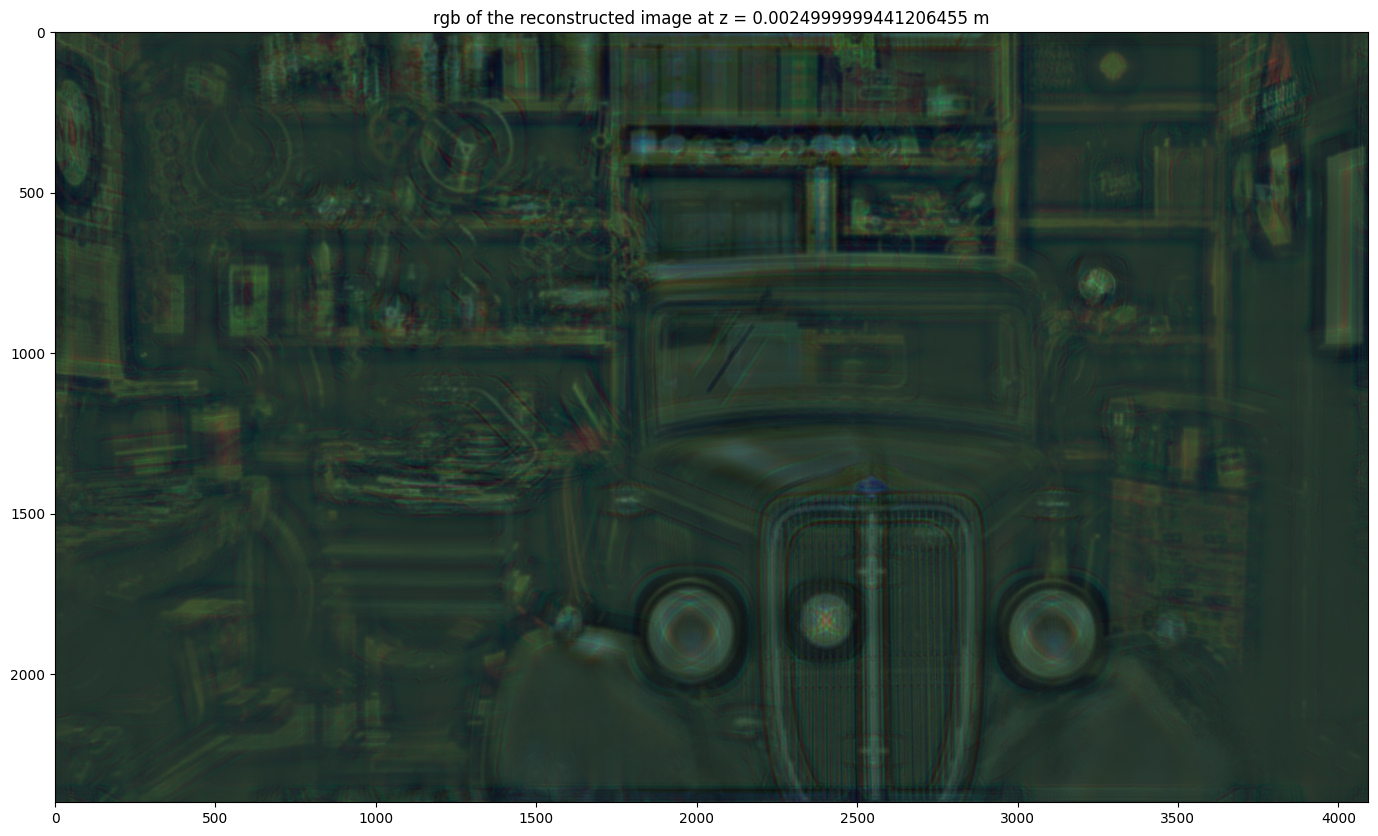

torch.Size([3, 2400, 4094])
torch.Size([3, 2400, 4094])


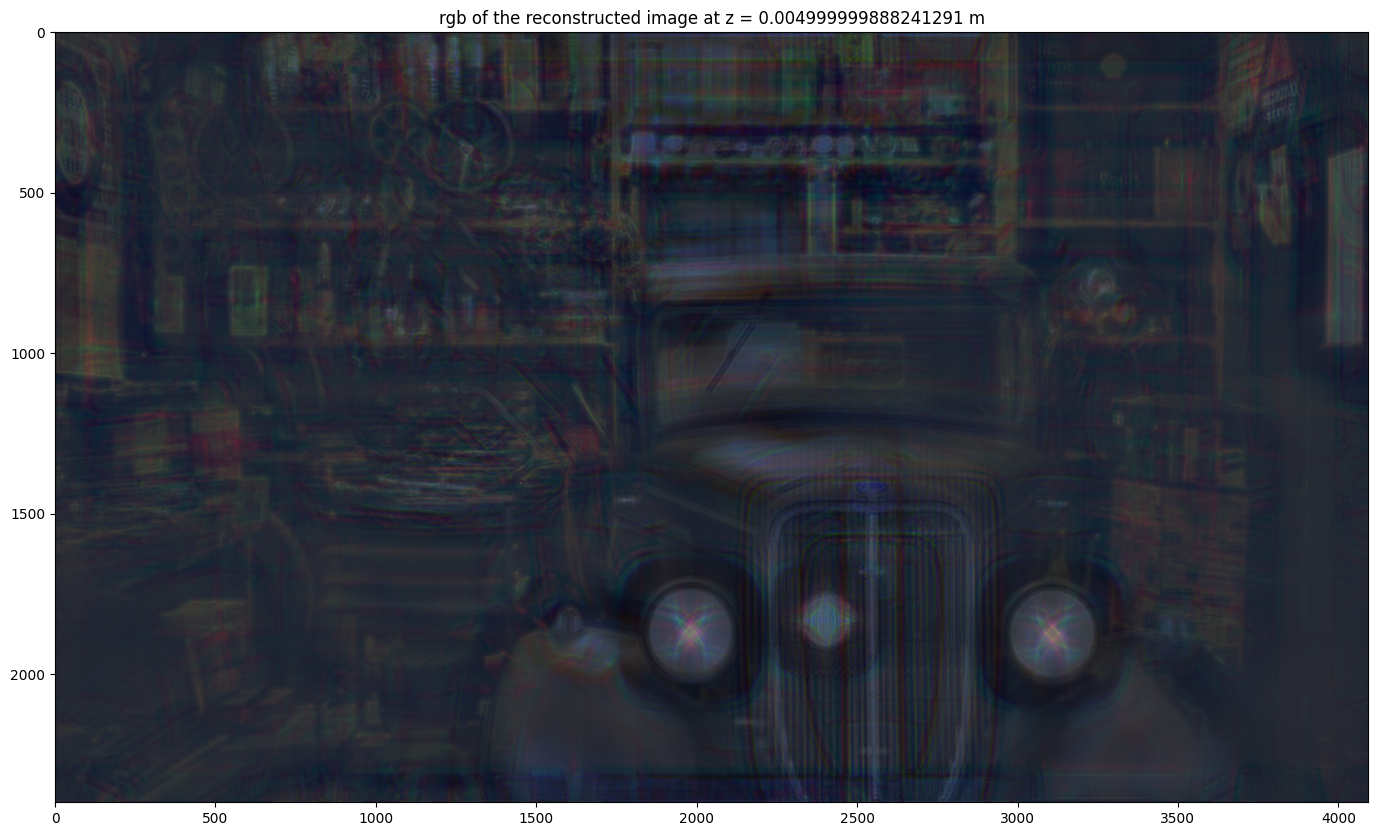

In [12]:
# generate a list of z values and take it into the function
propagation_distance = torch.linspace(0, 5e-3, 3)
for z in propagation_distance:
    g_z_complex, amplitude_z, phase_z = band_limited_angular_spectrum_multichannels(
        amplitudeTensor, phaseTensor, z=z, pixel_pitch=3.74e-6, band_limit=True, debug=False, plot=True, padded=False
    )    

# # save G_0 in csv file
# G_0_amplitude = torch.abs(G_0[0])
# plt.imshow(G_0_amplitude, cmap='hot')
# plt.axis('off')
# plt.title('Amplitude of G_0')
# plt.colorbar()
# plt.show()

# # save the amplitude of G_0 to csv file
# G_0_amplitude = G_0_amplitude.numpy()
# np.savetxt("G_0_amplitude.csv", G_0_amplitude, delimiter=",")



In [13]:
# # display the top 10 max values in G_0_amplitude and their location(row, column)in the tensor
# G_0_amplitude = torch.abs(G_0[0])
# G_0_amplitude = G_0_amplitude.numpy()
# G_0_amplitude_flatten = G_0_amplitude.flatten()
# top_10_max_values = np.sort(G_0_amplitude_flatten)[-10:]
# top_10_max_values_index = np.argsort(G_0_amplitude_flatten)[-10:]
# top_10_max_values_row = top_10_max_values_index // G_0_amplitude.shape[1]
# top_10_max_values_column = top_10_max_values_index % G_0_amplitude.shape[1]
# print(top_10_max_values)
# print(top_10_max_values_row)
# print(top_10_max_values_column)

# test

In [14]:
import odak

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 

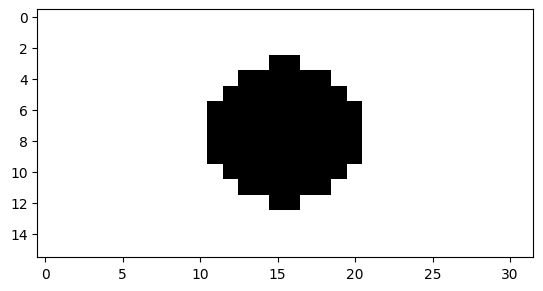

In [15]:
mask = -odak.learn.tools.mask.circular_binary_mask(16, 32, 5) + 1
plt.imshow(mask, cmap="gray")
print(mask)

In [16]:
def source_phase_tester(hologram_phases_filename="sample_hologram.png", device="cpu"):
    actual_hologram_phases = phase_image2phase_tensor(hologram_phases_filename)
    expected_hologram_phases = (
        odak.learn.tools.load_image(
            hologram_phases_filename, normalizeby=255.0, torch_style=True
        ).to(device)
        * odak.pi
        * 2
    )
    try:
        assert torch.allclose(actual_hologram_phases, expected_hologram_phases, atol=1e-10)
    except AssertionError:
        print("The source phase is not correct.")
        print(actual_hologram_phases.shape)
        print(expected_hologram_phases.shape)
        # plot the two phases
        plt.figure(figsize=(20, 10))
        plt.subplot(121)
        plt.imshow(actual_hologram_phases, cmap="gray", vmin=0, vmax=2 * math.pi)
        plt.title("Actual phase")
        plt.subplot(122)
        plt.imshow(expected_hologram_phases, cmap="gray", vmin=0, vmax=2 * math.pi)
        plt.title("Expected phase")
        plt.show()
        # plot the difference between the actual and expected phase
        plt.imshow(actual_hologram_phases - expected_hologram_phases, cmap="gray")
        plt.title("Difference between the actual and expected phase")
        plt.show()
        print(actual_hologram_phases - expected_hologram_phases)
        return actual_hologram_phases, expected_hologram_phases
    else:
        print("The source phase is correct.")
        return True
    
error_source_phase = source_phase_tester("sample_hologram.png")

The source phase is correct.


In [17]:
help(odak.learn.wave.propagator)

Help on class propagator in module odak.learn.wave.propagators:

class propagator(builtins.object)
 |  propagator(resolution=[1920, 1080], wavelengths=[5.15e-07], pixel_pitch=8e-06, resolution_factor=1, number_of_frames=1, number_of_depth_layers=1, volume_depth=0.01, image_location_offset=0.005, propagation_type='Bandlimited Angular Spectrum', propagator_type='back and forth', back_and_forth_distance=0.3, laser_channel_power=None, aperture=None, aperture_size=None, method='conventional', device=device(type='cpu'))
 |  
 |  A light propagation model that propagates light to desired image plane with two separate propagations. 
 |  We use this class in our various works including `Kavaklı et al., Realistic Defocus Blur for Multiplane Computer-Generated Holography`.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, input_field, channel_id, depth_id)
 |      Function that represents the forward model in hologram optimization.
 |      
 |      Parameters
 |      ----------
 |      input

## GPU time

In [18]:
# use the GPU to do a simple tensor operation and calculate the GPU time
tensor_a = torch.randn(10000, 10000).to("cuda")
tensor_b = torch.randn(10000, 10000).to("cuda")
torch.cuda.synchronize()
start_time = torch.cuda.Event(enable_timing=True) # create the timer
end_time = torch.cuda.Event(enable_timing=True) # create the timer
start_time.record()
tensor_c = tensor_a + tensor_b
end_time.record()
torch.cuda.synchronize()
gpu_time = start_time.elapsed_time(end_time)
print("The GPU time is {} ms".format(gpu_time))

The GPU time is 37.926849365234375 ms


f:\anaconda\envs\FYP\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


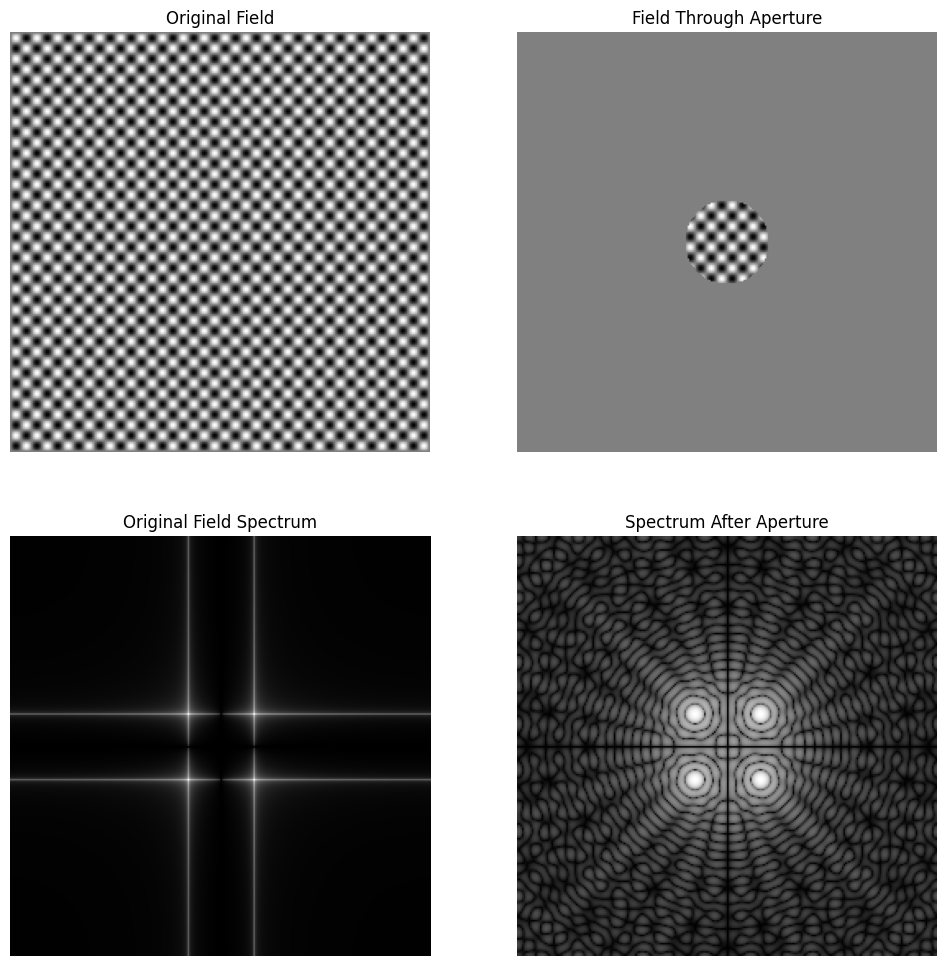

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 定义网格和aperture参数
grid_size = 256
L = 1e-3  # 网格物理尺寸
a = 0.1 * L  # aperture半径

# 创建网格
x = torch.linspace(-L/2, L/2, grid_size)
y = torch.linspace(-L/2, L/2, grid_size)
X, Y = torch.meshgrid(x, y)
R = torch.sqrt(X**2 + Y**2)

# 定义一个高频成分的光场（例如，细小结构）
U = torch.sin(20 * 2 * np.pi * X / L) * torch.sin(20 * 2 * np.pi * Y / L)

# 定义圆形aperture的透过率函数
aperture = (R <= a).float()

# 通过aperture的光场
U_aperture = U * aperture

# 计算傅里叶变换
U_fft = torch.fft.fftshift(torch.fft.fft2(U))
U_aperture_fft = torch.fft.fftshift(torch.fft.fft2(U_aperture))

# 计算幅度谱
U_fft_magnitude = torch.abs(U_fft)
U_aperture_fft_magnitude = torch.abs(U_aperture_fft)

# 可视化
plt.figure(figsize=(12, 12))

# 原始光场
plt.subplot(2, 2, 1)
plt.imshow(U.numpy(), cmap='gray')
plt.title('Original Field')
plt.axis('off')

# 通过aperture的光场
plt.subplot(2, 2, 2)
plt.imshow(U_aperture.numpy(), cmap='gray')
plt.title('Field Through Aperture')
plt.axis('off')

# 原始光场的幅度谱
plt.subplot(2, 2, 3)
plt.imshow(torch.log(U_fft_magnitude + 1).numpy(), cmap='gray')
plt.title('Original Field Spectrum')
plt.axis('off')

# 通过aperture的光场的幅度谱
plt.subplot(2, 2, 4)
plt.imshow(torch.log(U_aperture_fft_magnitude + 1).numpy(), cmap='gray')
plt.title('Spectrum After Aperture')
plt.axis('off')

plt.show()
